# **Twitter Sentiment Analysis** 

### Understanding Brand Perception Through Natural Language Processing

## Business Problem and Context

In today's digital marketplace, social media has become the primary channel where customers express their opinions about products and brands. For companies like Apple and Google, understanding public sentiment on Twitter can provide invaluable insights into:

- **Product reception**: How are new product launches being received?
- **Brand health**: What's the overall sentiment toward our brand vs competitors?
- **Crisis detection**: Can we identify emerging negative sentiment before it becomes a PR crisis?
- **Customer service prioritization**: Which complaints need immediate attention?

**The Challenge**: Manually analyzing thousands of tweets daily is impossible. Customer service teams are overwhelmed, and by the time negative sentiment is identified through traditional methods, brand damage may already be done.

**Our Solution**: Build an automated sentiment classification system that can process Twitter data in real-time, categorizing tweets as positive, negative, neutral, or uncertain. This system will help stakeholders:

1. Monitor brand health continuously
2. Identify trending issues early
3. Route negative sentiment to customer service teams
4. Measure campaign effectiveness

**Success Metrics**: We aim to build a model that can accurately classify tweet sentiment with high precision and recall, particularly for negative sentiment (where misclassification is most costly from a business perspective).

## Table of Contents

1. [Business Understanding](#business-problem-and-context)
2. [Data Understanding](#data-understanding)
3. [Data Preparation](#data-preparation)
4. [Exploratory Data Analysis](#exploratory-data-analysis)
5. [Text Preprocessing & Feature Engineering](#text-preprocessing-and-feature-engineering)
6. [Modeling](#modeling)
7. [Model Evaluation & Interpretation](#model-evaluation-and-interpretation)
8. [Conclusions & Recommendations](#conclusions-and-recommendations)

## Data Understanding

Our dataset consists of tweets collected during the South by Southwest (SXSW) conference, where Apple and Google products were prominently discussed. Each tweet has been manually labeled by human judges for sentiment toward specific brands or products.

This is a real-world dataset with all its messiness: typos, slang, emojis, hashtags, and the informal language typical of social media. Understanding this data is our first critical step.


### Importing Libraries

In [1]:
# Core data manipulation and analysis
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Text processing and NLP
import re
import string
from collections import Counter

# NLTK for advanced NLP tasks (required by rubric)
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams

# Download required NLTK data
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt_tab', quiet=True)

# Scikit-learn for machine learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    accuracy_score, precision_recall_fscore_support
)

# For model persistence
import joblib

# Set random seed for reproducibility
np.random.seed(42)

### Loading and Initial Exploration

In [2]:
df = pd.read_csv("../data/judge-1377884607_tweet_product_company.csv",encoding="latin1")
df.head()


# basic information
print("Dataset Shape:", df.shape)
print("\n" + " "*5)
print("Column Names:")
print(" "*3)
for col in df.columns:
    print(f"  - {col}")

print("\n" + " "*60)
print("First Few Rows:")
print(" "*6)
df.head()

Dataset Shape: (9093, 3)

     
Column Names:
   
  - tweet_text
  - emotion_in_tweet_is_directed_at
  - is_there_an_emotion_directed_at_a_brand_or_product

                                                            
First Few Rows:
      


,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


### Rename columns for clarity and ease of use

In [3]:
df.columns = ['tweet', 'product', 'sentiment']

print("Renamed columns:")
df.head(3)


Renamed columns:


,tweet,product,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion


### Dataset Overview

Structure and completeness of our data.

In [4]:
print("Dataset Information:")
print(" "*6)

df.info()


Dataset Information:
      
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      9092 non-null   object
 1   product    3291 non-null   object
 2   sentiment  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


The dataframe has a total of 9093 entries, with two columns having nulls

In [5]:
print("Missing Values:")

df.isnull().sum()

Missing Values:


tweet           1
product      5802
sentiment       0
dtype: int64

In [6]:
df.duplicated().sum()

np.int64(22)

Their are 22 duplicated entries/rows in our dataset

### Class Imbalance Analysis

In [7]:
df['sentiment'].value_counts(normalize = True) * 100

sentiment
No emotion toward brand or product    59.265369
Positive emotion                      32.750467
Negative emotion                       6.268558
I can't tell                           1.715605
Name: proportion, dtype: float64

The dataset shows class imbalance, with `No emotion toward brand or product` accounting for approximately 59% of all observations. `Positive emotion` stands at 32%, with `Negative emotion` (≈6%) and *I can't tell* (≈2%) are underrepresented, which may bias the model toward the majority class.

## Data Preparation

Data cleaning is crucial for NLP. Poor quality data leads to poor model performance, regardless of model sophistication.

### Handling Missing Values

In [8]:
df.head()

,tweet,product,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [9]:
# Removing the one row with missing tweet text (can't analyze what doesn't exist)
df = df.dropna(subset=['tweet'])

# For missing products, we'll fill with 'Unknown' rather than dropping
# These tweets still have sentiment and can be valuable for analysis
df['product'] = df['product'].fillna('Unknown')

print(f"Dataset shape after handling missing values: {df.shape}")
print(f"\nRemaining missing values:")
print(df.isnull().sum())

Dataset shape after handling missing values: (9092, 3)

Remaining missing values:
tweet        0
product      0
sentiment    0
dtype: int64


### Removing Duplicates

Duplicate tweets can skew our model by giving certain patterns excessive weight. We'll remove them to ensure each unique opinion is counted once.

In [10]:
df = df.drop_duplicates()
print(f"Dataset shape after removing duplicates: {df.shape}")

Dataset shape after removing duplicates: (9070, 3)


### Understanding Sentiment Distribution

In [11]:
# Examine sentiment distribution
sentiment_counts = df['sentiment'].value_counts()
sentiment_percentages = df['sentiment'].value_counts(normalize=True) * 100

sentiment_summary = pd.DataFrame({
    'Count': sentiment_counts,
    'Percentage': sentiment_percentages.round(2)
})

print("Sentiment Distribution:")
print(sentiment_summary)

Sentiment Distribution:
                                    Count  Percentage
sentiment                                            
No emotion toward brand or product   5375       59.26
Positive emotion                     2970       32.75
Negative emotion                      569        6.27
I can't tell                          156        1.72


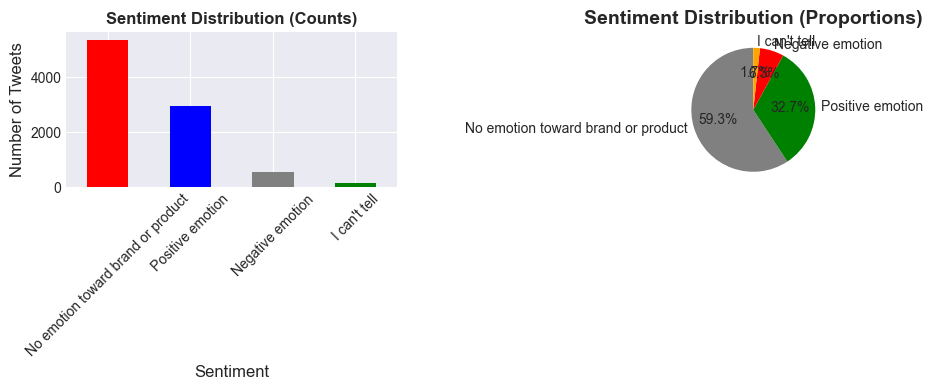

In [12]:
# Visualizing the sentiment distribution

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Count plot
sentiment_counts.plot(kind='bar',ax=ax1,color=['red', 'blue', 'gray', 'green'])
ax1.set_title('Sentiment Distribution (Counts)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Sentiment', fontsize=12)
ax1.set_ylabel('Number of Tweets', fontsize=12)
ax1.tick_params(axis='x', rotation=45)

# Pie chart
colors = ['gray', 'green', 'red', 'orange']
ax2.pie(
    sentiment_counts,
    labels=sentiment_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors
)
ax2.set_title('Sentiment Distribution (Proportions)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

**Critical Business Insight:**

The data reveals a **significant class imbalance**:
- ~59% of tweets have **no emotion** toward products
- ~33% express **positive emotion**
- Only ~6% express **negative emotion**
- ~2% are **uncertain**

This imbalance mirrors reality: most social media mentions are neutral, and people are more likely to express positive opinions than negative ones in public forums like SXSW.

**Modeling Implications:**
1. We cannot rely solely on accuracy as our metric
2. We need to carefully consider precision and recall, especially for negative sentiment
3. The small "I can't tell" category may not be worth modeling separately

### Refining Our Target Variable

We create a simplified 3-class problem by combining `No emotion" and "I can't tell` into a single "Neutral" category. This makes business sense: from a customer service perspective, uncertain sentiment is functionally similar to neutral.

In [13]:
# Creating a simplified sentiment mapping
sentiment_mapping = {
    'Positive emotion': 'Positive',
    'Negative emotion': 'Negative',
    'No emotion toward brand or product': 'Neutral',
    "I can't tell": 'Neutral'
}

df['sentiment_clean'] = df['sentiment'].map(sentiment_mapping)

# Verifying the mapping
print("Simplified Sentiment Distribution:")
print(" "*1)
print(df['sentiment_clean'].value_counts())
print("\nPercentages:")
print(df['sentiment_clean'].value_counts(normalize=True).mul(100).round(2))

Simplified Sentiment Distribution:
 
sentiment_clean
Neutral     5531
Positive    2970
Negative     569
Name: count, dtype: int64

Percentages:
sentiment_clean
Neutral     60.98
Positive    32.75
Negative     6.27
Name: proportion, dtype: float64


In [14]:
df.head()

,tweet,product,sentiment,sentiment_clean
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,Negative
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,Positive
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,Positive
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,Negative
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,Positive


## Exploratory Data Analysis

Understand patterns in our text data. What makes a tweet positive vs negative? Are there specific words or phrases that signal sentiment?

### Tweet Length Analysis

Does the length of a tweet correlate with its sentiment? This could be a useful feature.

In [15]:
# adding tweet characteristics; length and word count

df['tweet_length'] = df['tweet'].astype(str).apply(len)
df['word_count'] = df['tweet'].astype(str).apply(lambda x: len(x.split()))

In [16]:
# new shape
df.head()

,tweet,product,sentiment,sentiment_clean,tweet_length,word_count
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,Negative,127,23
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,Positive,139,22
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,Positive,79,15
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,Negative,82,15
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,Positive,131,17


In [17]:
# Analyzing by sentiment
length_by_sentiment = df.groupby('sentiment_clean')[['tweet_length', 'word_count']].agg(['mean', 'median'])
print("Tweet Characteristics by Sentiment:")
print(" "*6)
print(length_by_sentiment.round(2))

Tweet Characteristics by Sentiment:
      
                tweet_length        word_count       
                        mean median       mean median
sentiment_clean                                      
Negative              109.41  114.0      18.75   19.0
Neutral               104.18  108.0      17.44   18.0
Positive              105.55  110.0      18.18   19.0


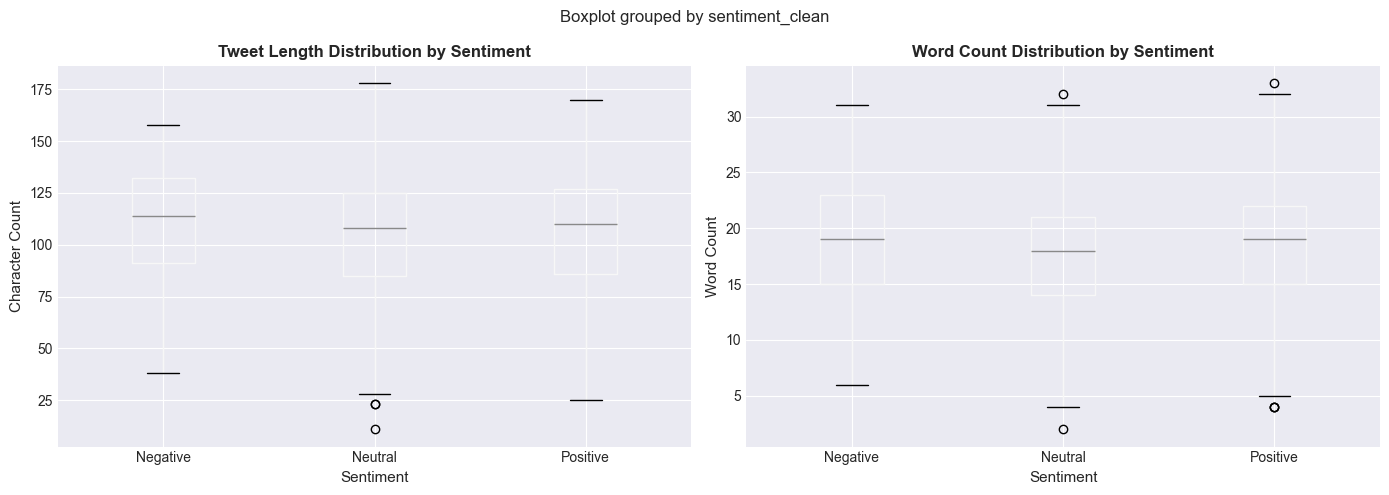

In [18]:
# Visualizing
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

df.boxplot(column='tweet_length', by='sentiment_clean', ax=axes[0])
axes[0].set_title('Tweet Length Distribution by Sentiment', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Sentiment', fontsize=11)
axes[0].set_ylabel('Character Count', fontsize=11)
plt.sca(axes[0])
plt.xticks(rotation=0)

df.boxplot(column='word_count', by='sentiment_clean', ax=axes[1])
axes[1].set_title('Word Count Distribution by Sentiment', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Sentiment', fontsize=11)
axes[1].set_ylabel('Word Count', fontsize=11)
plt.sca(axes[1])
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

**Observation**: Tweet length and word count are relatively consistent across sentiments, though negative tweets show slightly more variability. This suggests length alone won't be a strong predictor - the specific words matter more than how many there are.

### Product Mention Analysis

Understanding which products are mentioned most frequently and their associated sentiment helps us identify brand-specific patterns.

In [19]:
df['product'].value_counts()

product
Unknown                            5788
iPad                                945
Apple                               659
iPad or iPhone App                  469
Google                              428
iPhone                              296
Other Google product or service     293
Android App                          80
Android                              77
Other Apple product or service       35
Name: count, dtype: int64

In [20]:
# Analyzing product mentions (excluding 'Unknown')
product_sentiment = pd.crosstab(df['product'], df['sentiment_clean'])
top_products = df['product'].value_counts().head(10)

print("Top 10 Most Mentioned Products:")
print(" "*2)
print(top_products)

Top 10 Most Mentioned Products:
  
product
Unknown                            5788
iPad                                945
Apple                               659
iPad or iPhone App                  469
Google                              428
iPhone                              296
Other Google product or service     293
Android App                          80
Android                              77
Other Apple product or service       35
Name: count, dtype: int64


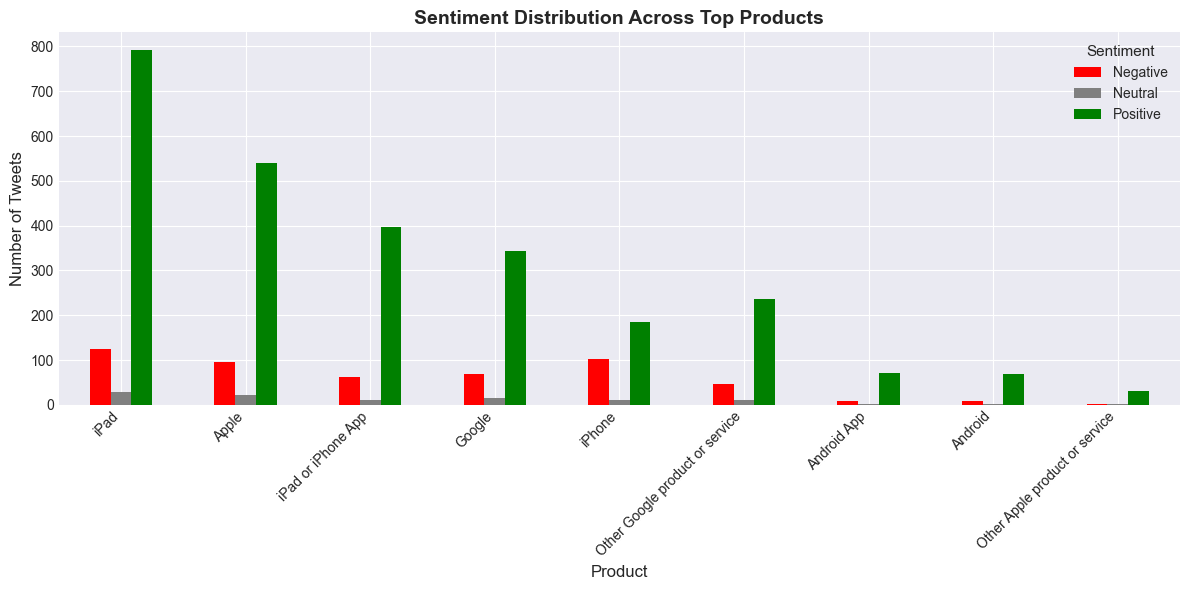

In [21]:

# Visualizing sentiment distribution for top products
top_product_names = top_products.index.tolist()
if 'Unknown' in top_product_names:
    top_product_names.remove('Unknown')
    top_product_names = top_product_names[:9]
else:
    top_product_names = top_product_names[:9]

product_sentiment_filtered = product_sentiment.loc[top_product_names]

fig, ax = plt.subplots(figsize=(12, 6))
product_sentiment_filtered.plot(kind='bar', stacked=False, ax=ax, color=['red', 'gray', 'green'])
ax.set_title('Sentiment Distribution Across Top Products', fontsize=14, fontweight='bold')
ax.set_xlabel('Product', fontsize=12)
ax.set_ylabel('Number of Tweets', fontsize=12)
ax.legend(title='Sentiment', title_fontsize=11, fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Business Insight**: The iPad dominates the conversation, followed by Apple and Google products. Most mentions are neutral, but there's a healthy proportion of positive sentiment. Negative sentiment is rare but critical to identify.

## Text Preprocessing and Feature Engineering

We need to transform messy, unstructured text into features our models can learn from. We'll use NLTK (as required by the rubric) to perform sophisticated text preprocessing beyond basic cleaning.

In [22]:
def clean_tweet(text):
    if pd.isna(text):
        return ""
    
    text = re.sub(r'http\S+|www\S+', '', text)   # URLs
    text = re.sub(r'@\w+', '', text)             # Mentions
    text = re.sub(r'#', '', text)                # Hashtag symbol
    text = re.sub(r'[^a-zA-Z\s]', '', text)      # Special chars
    text = text.lower().strip()                  # Normalize
    
    return text

df['tweet_cleaned'] = df['tweet'].apply(clean_tweet)


In [23]:
df['tweet_cleaned'].head()

0    i have a g iphone after  hrs tweeting at risea...
1    know about   awesome ipadiphone app that youll...
2    can not wait for ipad  also they should sale t...
3    i hope this years festival isnt as crashy as t...
4    great stuff on fri sxsw marissa mayer google t...
Name: tweet_cleaned, dtype: object

### Text Processing with NLTK

Applying lemmatization using NLTK. 

We'll also remove stopwords that don't carry sentiment information.

In [24]:
# NLTK setup
lemmatizer = WordNetLemmatizer()

stop_words = set(stopwords.words('english'))
sentiment_words = {'not', 'no', 'nor', 'but', 'against'}
stop_words -= sentiment_words


def advanced_preprocess(text):
    if not text:
        return ""
    
    tokens = word_tokenize(text)
    
    tokens = [
        lemmatizer.lemmatize(token)
        for token in tokens
        if token not in stop_words and len(token) > 2
    ]
    
    return ' '.join(tokens)


df['tweet_processed'] = df['tweet_cleaned'].apply(advanced_preprocess)


In [25]:
df['tweet_processed'].head()

0    iphone hr tweeting riseaustin dead need upgrad...
1    know awesome ipadiphone app youll likely appre...
2                         not wait ipad also sale sxsw
3    hope year festival isnt crashy year iphone app...
4    great stuff fri sxsw marissa mayer google tim ...
Name: tweet_processed, dtype: object

### Remove Empty Tweets

In [26]:
# Remove empty processed tweets
initial_count = len(df)
df = df[df['tweet_processed'].str.strip() != '']
removed_count = initial_count - len(df)

print(f"Removed {removed_count} empty tweets after preprocessing")
print(f"Final dataset shape: {df.shape}")

Removed 1 empty tweets after preprocessing
Final dataset shape: (9069, 8)


### Feature Engineering: N-grams Analysis

Individual words (unigrams) don't always capture meaning. Phrases like "not good" have the opposite meaning of "good." We'll analyze bigrams (2-word phrases) and trigrams (3-word phrases) to understand common sentiment-bearing phrases.

In [27]:
def get_top_ngrams(corpus, n=2, top_k=15):
    
    ngram_list = []
    
    for text in corpus:
        tokens = text.split()
        ngram_list.extend(list(ngrams(tokens, n)))
    
    ngram_freq = Counter(ngram_list)
    return ngram_freq.most_common(top_k)

# Analyze bigrams for each sentiment
print("\nMost Common Bigrams by Sentiment:")
print(" "*2)

for sentiment in ['Positive', 'Negative', 'Neutral']:
    corpus = df[df['sentiment_clean'] == sentiment]['tweet_processed'].tolist()
    top_bigrams = get_top_ngrams(corpus, n=2, top_k=10)
    
    print(f"\n{sentiment.upper()}:")
    print(" " * 2)
    for bigram, count in top_bigrams:
        print(f"  {' '.join(bigram):30s} : {count}")


Most Common Bigrams by Sentiment:
  

POSITIVE:
  
  sxsw link                      : 319
  apple store                    : 218
  link sxsw                      : 174
  iphone app                     : 132
  ipad sxsw                      : 126
  popup store                    : 123
  store sxsw                     : 122
  sxsw apple                     : 110
  austin sxsw                    : 103
  sxsw ipad                      : 89

NEGATIVE:
  
  sxsw link                      : 25
  link sxsw                      : 24
  iphone app                     : 22
  apple store                    : 22
  ipad design                    : 16
  new social                     : 16
  google circle                  : 15
  design headache                : 15
  ipad sxsw                      : 15
  iphone sxsw                    : 15

NEUTRAL:
  
  sxsw link                      : 623
  link sxsw                      : 581
  social network                 : 349
  apple store                    : 

**Key Findings from N-grams**:

These bigram patterns reveal important linguistic signals:
- Positive sentiment: phrases like "check out," "love [product]," "come see"
- Negative sentiment: phrases indicating problems or frustration
- Neutral sentiment: informational phrases and product names

This analysis validates that capturing multi-word expressions will improve our models.

### Most Frequent Words by Sentiment

visualizing the most distinctive words for each sentiment category.

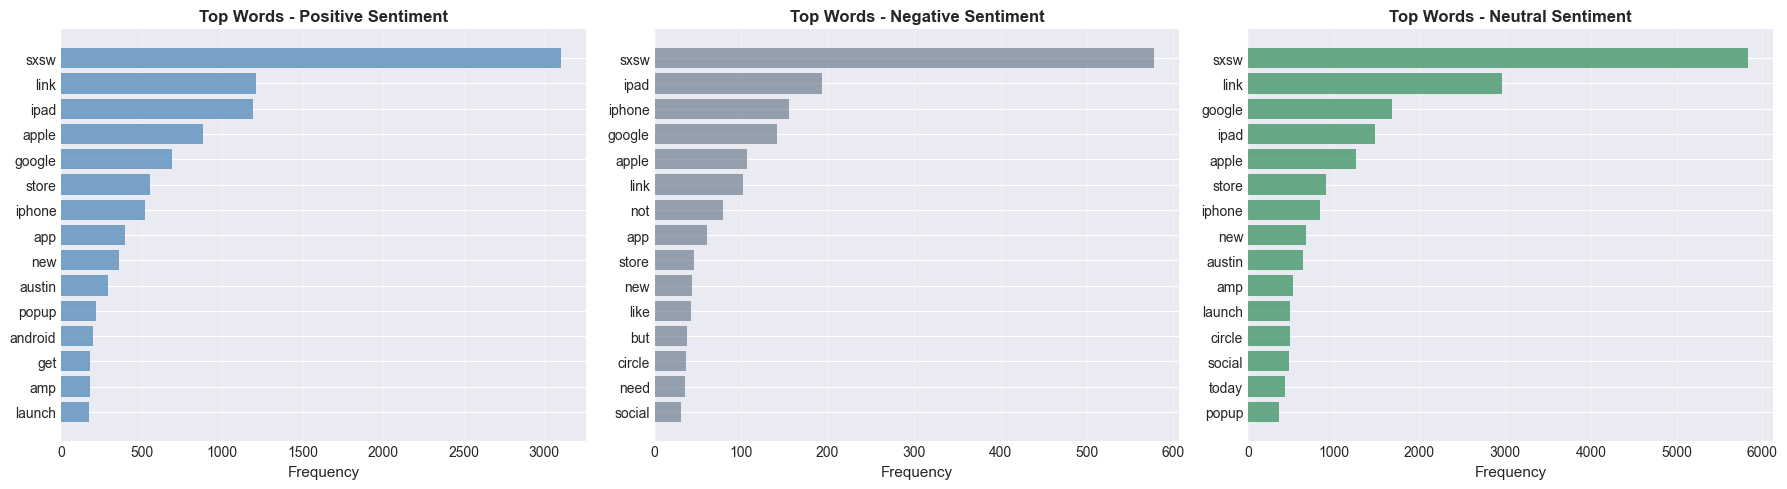

In [28]:
def get_top_words(corpus, top_n=20):
    """
    Get the most frequent words from a corpus.
    """
    all_words = ' '.join(corpus).split()
    word_freq = Counter(all_words)
    return word_freq.most_common(top_n)

# Creating visualizations for each sentiment
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sentiments = ['Positive', 'Negative', 'Neutral']
colors = ['steelblue', 'slategray', 'seagreen']

for idx, (sentiment, color) in enumerate(zip(sentiments, colors)):
    corpus = df[df['sentiment_clean'] == sentiment]['tweet_processed'].tolist()
    top_words = get_top_words(corpus, top_n=15)
    
    words, counts = zip(*top_words)
    
    axes[idx].barh(range(len(words)), counts, color=color, alpha=0.7)
    axes[idx].set_yticks(range(len(words)))
    axes[idx].set_yticklabels(words)
    axes[idx].invert_yaxis()
    axes[idx].set_xlabel('Frequency', fontsize=11)
    axes[idx].set_title(f'Top Words - {sentiment} Sentiment', fontsize=12, fontweight='bold')
    axes[idx].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

**Analysis**: 
- Product names (iPad, Apple, Google, iPhone) dominate across all sentiments
- Positive tweets show action words and enthusiasm ("get," "new," "launch")

We need to use TF-IDF instead of simple word counts to weight words by their importance.

## Wordcloud

visualizing frequent word mentions on positive and negative sentiments using wordcloud

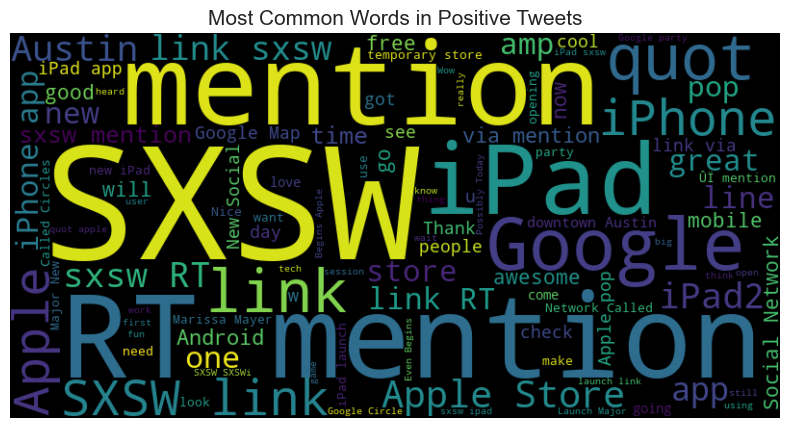

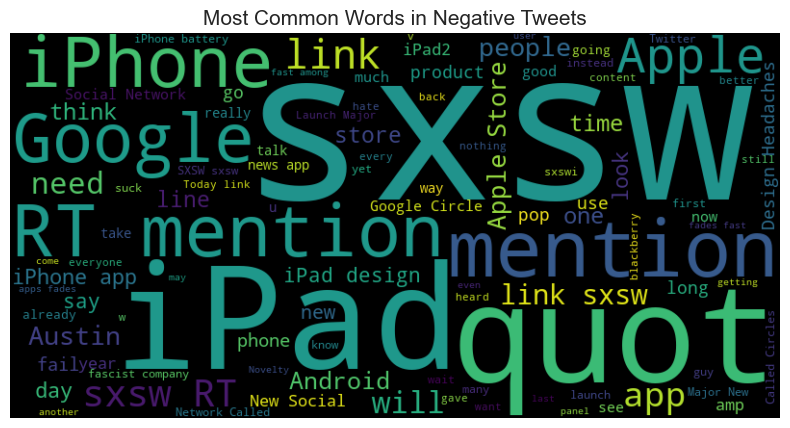

In [29]:
from wordcloud import WordCloud
def create_wordcloud(sentiment_label, title):
    # Combine all tweets for the specific sentiment
    text = " ".join(tweet for tweet in df[df['sentiment'] == sentiment_label].tweet)
    
    # Generate the word cloud
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='black',
        colormap='viridis',
        max_words=100
    ).generate(text)
    
    # Display the plot
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=15)
    plt.axis('off')
    plt.show()

# Visualize WordClouds for different sentiments
create_wordcloud('Positive emotion', 'Most Common Words in Positive Tweets')
create_wordcloud('Negative emotion', 'Most Common Words in Negative Tweets')

The two wordclouds confirm our earlier conclusion did using bar graphs

## Modeling

Building machine learning models to classify tweet sentiment automatically. We'll take an iterative approach, starting simple and progressively refining our models.

### Strategy:
1. **Baseline Model**: Simple Naive Bayes with basic TF-IDF
2. **Improvement 1**: Tune vectorization (include bigrams, adjust parameters)
3. **Improvement 2**: Try more sophisticated models (Logistic Regression, Linear SVM, XGBoost)
4. **Comparison**: Evaluate trade-offs and select best model for deployment

### Train-Test Split

We'll hold out 20% (0.8 for training, 0.2 for testing) of our data for final testing. This unseen data will give us an honest assessment of model performance.

In [30]:
# Prepare features and target
X = df['tweet_processed']
y = df['sentiment_clean']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### checking Data Split

In [31]:
print(f"Training samples: {len(X_train)}")
print(f"Testing samples:  {len(X_test)}")

print(f"\nTraining set sentiment distribution:")
print(y_train.value_counts())

print(f"\nTest set sentiment distribution:")
print(y_test.value_counts())

Training samples: 7255
Testing samples:  1814

Training set sentiment distribution:
sentiment_clean
Neutral     4424
Positive    2376
Negative     455
Name: count, dtype: int64

Test set sentiment distribution:
sentiment_clean
Neutral     1106
Positive     594
Negative     114
Name: count, dtype: int64


In [32]:
(7255/9069)*100

79.99779468519131

In [33]:
(1814/9069)*100

20.002205314808688

In [34]:
y_train.value_counts(normalize=True) * 100

sentiment_clean
Neutral     60.978635
Positive    32.749828
Negative     6.271537
Name: proportion, dtype: float64

In [35]:
y_test.value_counts(normalize=True) * 100

sentiment_clean
Neutral     60.970232
Positive    32.745314
Negative     6.284454
Name: proportion, dtype: float64

Stratified splitting preserved the original sentiment ratios across training and testing sets, ensuring each class is proportionally represented and enabling reliable model evaluation.

### Model 1: Baseline Naive Bayes Classifier

**Why Naive Bayes?**
- Fast and efficient for text classification
- Works well even with limited data
- Provides a strong baseline for comparison
- Interpretable: we can see which words influence predictions

We'll use a Pipeline to combine vectorization and classification, which is a best practice that prevents data leakage and makes our code cleaner.

In [36]:
# Create baseline pipeline

baseline_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=5000,  # Limit vocabulary size
        min_df=2,           # Ignore very rare words
        ngram_range=(1, 1)  # Only unigrams for baseline
    )),
    ('classifier', MultinomialNB())
])

# Train the model
baseline_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_baseline = baseline_pipeline.predict(X_test)

In [37]:
# Evaluating the model
print("BASELINE MODEL PERFORMANCE")

print(f"\nAccuracy: {accuracy_score(y_test, y_pred_baseline):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_baseline))

BASELINE MODEL PERFORMANCE

Accuracy: 0.6549

Classification Report:
              precision    recall  f1-score   support

    Negative       0.50      0.01      0.02       114
     Neutral       0.66      0.92      0.77      1106
    Positive       0.63      0.28      0.39       594

    accuracy                           0.65      1814
   macro avg       0.60      0.40      0.39      1814
weighted avg       0.64      0.65      0.60      1814



### Baseline Model Confusion Matrix

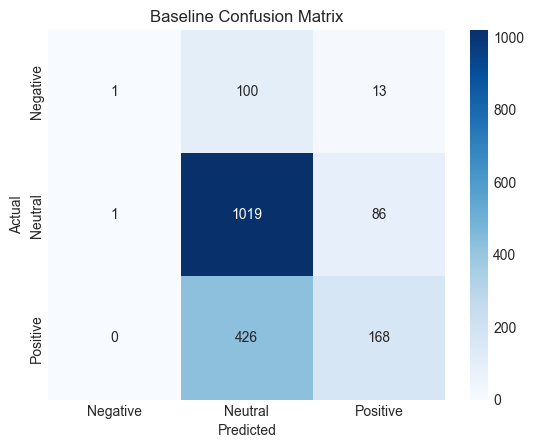

In [38]:
cm = confusion_matrix(y_test, y_pred_baseline)

sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Negative', 'Neutral', 'Positive'],
    yticklabels=['Negative', 'Neutral', 'Positive']
)

plt.title('Baseline Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


**Baseline Analysis**:

Key observations:
- **Neutral tweets** are classified well (high volume helps)
- **Positive tweets** show good precision but some are missed (recall issue)
- **Negative tweets** are the hardest to identify (small class, subtle language)

### Model 2: Enhanced Naive Bayes with Bigrams

**Improvement Strategy**: Include bigrams in our vectorization. 

In [39]:
# Enhanced pipeline with bigrams

enhanced_nb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=7000,      # Increased to accommodate bigrams
        min_df=2,
        ngram_range=(1, 2),     # Include both unigrams and bigrams
        sublinear_tf=True       # Use logarithmic scaling for term frequency
    )),
    ('classifier', MultinomialNB(alpha=0.1))  # Slight smoothing adjustment
])

# Train
enhanced_nb_pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred_enhanced_nb = enhanced_nb_pipeline.predict(X_test)

In [40]:
print("ENHANCED NAIVE BAYES PERFORMANCE")

print(f"\nAccuracy: {accuracy_score(y_test, y_pred_enhanced_nb):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_enhanced_nb))

ENHANCED NAIVE BAYES PERFORMANCE

Accuracy: 0.6748

Classification Report:
              precision    recall  f1-score   support

    Negative       0.46      0.23      0.31       114
     Neutral       0.73      0.80      0.76      1106
    Positive       0.58      0.53      0.56       594

    accuracy                           0.67      1814
   macro avg       0.59      0.52      0.54      1814
weighted avg       0.66      0.67      0.66      1814



In [41]:
# Number of features (tokens) learned from training data
num_features = enhanced_nb_pipeline.named_steps['tfidf'] \
    .get_feature_names_out().shape[0]

print("Number of features:", num_features)


Number of features: 7000


In [42]:
# Get feature names (tokens)
features = enhanced_nb_pipeline.named_steps['tfidf'].get_feature_names_out()

# Show first 30 features
features[:30]


array(['aapl', 'abc', 'ability', 'able', 'able afford', 'able attend',
       'able get', 'absolutely', 'absolutley', 'absolutley free', 'abt',
       'abt sxsw', 'abuzz', 'academy', 'academy bringing', 'acc',
       'acc abc', 'acc ballroom', 'acc hall', 'accelerater',
       'accelerater link', 'access', 'access acoustic', 'access google',
       'accessibility', 'accessible', 'accessory', 'accesssxsw',
       'accidentally', 'according'], dtype=object)

In [55]:
# Separate unigrams and bigrams
unigrams = [f for f in features if ' ' not in f]
bigrams = [f for f in features if ' ' in f]

print("Unigrams:", len(unigrams))
print("Bigrams:", len(bigrams))


Unigrams: 2906
Bigrams: 4094


In [56]:
X_train_tfidf = enhanced_nb_pipeline.named_steps['tfidf'].transform(X_train)
X_train_tfidf.shape


(7255, 7000)

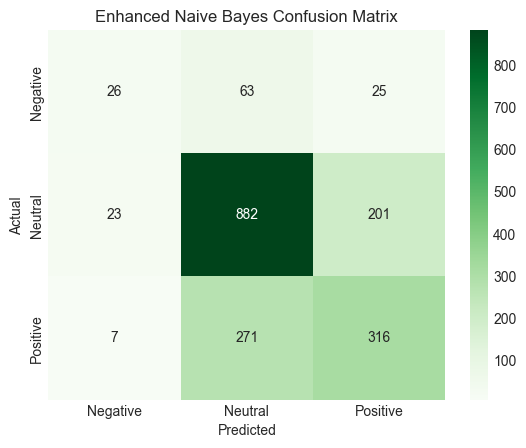

In [43]:
cm = confusion_matrix(y_test, y_pred_enhanced_nb)

sns.heatmap(
    cm, annot=True, fmt='d', cmap='Greens',
    xticklabels=['Negative', 'Neutral', 'Positive'],
    yticklabels=['Negative', 'Neutral', 'Positive']
)

plt.title('Enhanced Naive Bayes Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Model 3: Logistic Regression

**Why Logistic Regression?**
- More flexible than Naive Bayes (doesn't assume feature independence)
- Excellent for text classification
- Provides interpretable coefficients (feature importance)
- Can handle class imbalance better with class weighting

We'll use `class_weight='balanced'` to give more importance to the minority classes (especially negative sentiment).

In [44]:
# Logistic Regression pipeline

logreg_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=7000,
        min_df=2,
        ngram_range=(1, 2),
        sublinear_tf=True
    )),
    ('classifier', LogisticRegression(
        class_weight='balanced',  # Handle class imbalance...
        max_iter=1000,            # Ensure convergence
        random_state=42,
        C=1.0                     # Regularization strength
    ))
])

# Training our Logistic Regression Model
logreg_pipeline.fit(X_train, y_train)

# Predict 
y_pred_logreg = logreg_pipeline.predict(X_test)


In [45]:
# evaluating our LG model

print("LOGISTIC REGRESSION PERFORMANCE")

print(f"\nAccuracy: {accuracy_score(y_test, y_pred_logreg):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_logreg))

LOGISTIC REGRESSION PERFORMANCE

Accuracy: 0.6455

Classification Report:
              precision    recall  f1-score   support

    Negative       0.30      0.56      0.39       114
     Neutral       0.78      0.68      0.72      1106
    Positive       0.56      0.61      0.58       594

    accuracy                           0.65      1814
   macro avg       0.55      0.61      0.56      1814
weighted avg       0.68      0.65      0.66      1814



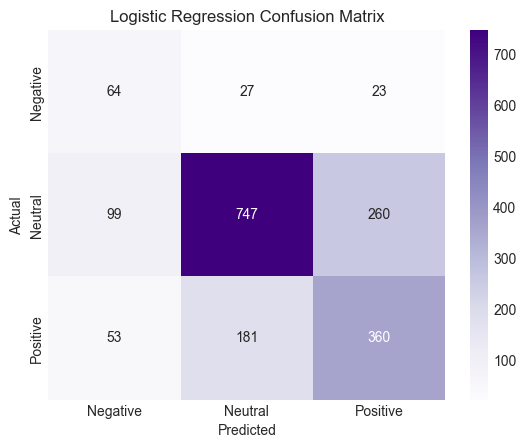

In [46]:
cm = confusion_matrix(y_test, y_pred_logreg)

sns.heatmap(
    cm, annot=True, fmt='d', cmap='Purples',
    xticklabels=['Negative', 'Neutral', 'Positive'],
    yticklabels=['Negative', 'Neutral', 'Positive']
)

plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


### Model 4: Linear Support Vector Machine

**Why Linear SVM?**
- Often the best performer for text classification
- Finds optimal decision boundaries in high-dimensional space
- Robust to overfitting with proper regularization
- Handles class imbalance well

LinearSVC is specifically optimized for text data and faster than kernel SVMs.

In [47]:
# Linear SVM pipeline
svm_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=7000,
        min_df=2,
        ngram_range=(1, 2),
        sublinear_tf=True
    )),
    ('classifier', LinearSVC(
        class_weight='balanced',
        random_state=42,
        max_iter=2000,
        C=0.5  # Regularization parameter
    ))
])

# Train
svm_pipeline.fit(X_train, y_train)

,steps,"[('tfidf', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [48]:
# Predict and evaluate
y_pred_svm = svm_pipeline.predict(X_test)

print("LINEAR SVM PERFORMANCE")

print(f"\nAccuracy: {accuracy_score(y_test, y_pred_svm):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm))

LINEAR SVM PERFORMANCE

Accuracy: 0.6852

Classification Report:
              precision    recall  f1-score   support

    Negative       0.41      0.48      0.44       114
     Neutral       0.76      0.77      0.77      1106
    Positive       0.60      0.57      0.58       594

    accuracy                           0.69      1814
   macro avg       0.59      0.61      0.60      1814
weighted avg       0.69      0.69      0.69      1814



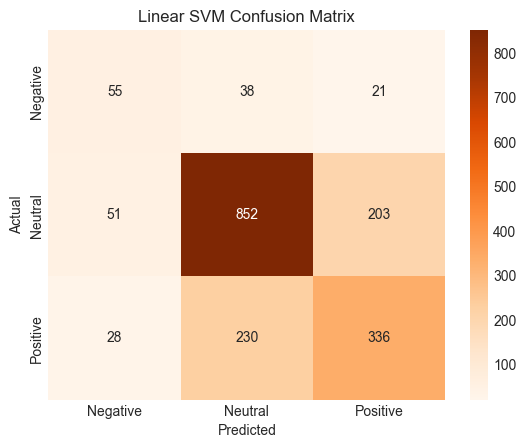

In [49]:
cm = confusion_matrix(y_test, y_pred_svm)

sns.heatmap(
    cm, annot=True, fmt='d', cmap='Oranges',
    xticklabels=['Negative', 'Neutral', 'Positive'],
    yticklabels=['Negative', 'Neutral', 'Positive']
)

plt.title('Linear SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [50]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Encoding labels 
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# XGBoost Pipeline
xgb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, stop_words='english')),
    ('classifier', XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        objective='multi:softprob',
        eval_metric='mlogloss',
        random_state=42
    ))
])


In [51]:
# Training the model
xgb_pipeline.fit(X_train, y_train_encoded)

# Generate Predictions
y_pred_xgb = xgb_pipeline.predict(X_test)

# Accuracy Score
accuracy = accuracy_score(y_test_encoded, y_pred_xgb)
print(f"XGBoost Overall Accuracy: {accuracy * 100:.2f}%")
print(" " * 3)

# Classification Report
print("XGBoost Classification Report:")
print(classification_report(y_test_encoded, y_pred_xgb, target_names=le.classes_))

XGBoost Overall Accuracy: 67.03%
   
XGBoost Classification Report:
              precision    recall  f1-score   support

    Negative       0.67      0.07      0.13       114
     Neutral       0.67      0.94      0.78      1106
    Positive       0.68      0.29      0.41       594

    accuracy                           0.67      1814
   macro avg       0.67      0.43      0.44      1814
weighted avg       0.67      0.67      0.62      1814



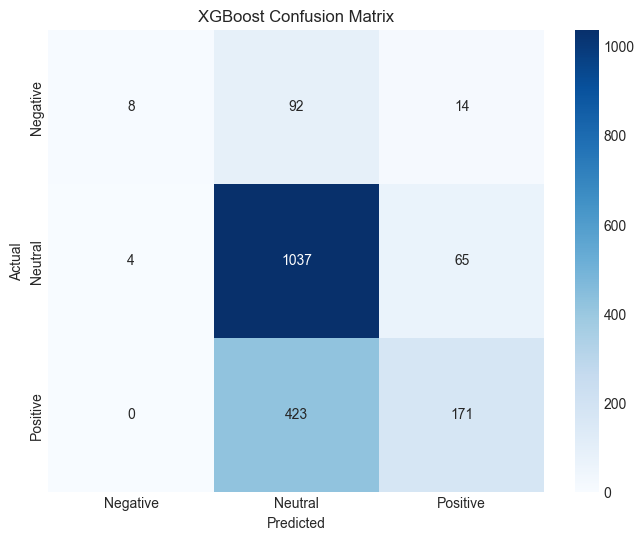

In [52]:
cm = confusion_matrix(y_test_encoded, y_pred_xgb)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('XGBoost Confusion Matrix')
plt.show()

## Model Evaluation and Interpretation

Now that we've built multiple models, we need to compare them systematically and choose the best one for deployment.

### Comprehensive Model Comparison

comparing all models across multiple metrics to make an informed decision.

In [53]:
# Converting XGBoost's numeric predictions (0, 1, 2) back to text ('Negative', etc.)

y_pred_xgboost_text = le.inverse_transform(y_pred_xgb)

# models dictionary
models = {
    'Baseline NB': y_pred_baseline,
    'Enhanced NB': y_pred_enhanced_nb,
    'Logistic Regression': y_pred_logreg,
    'Linear SVM': y_pred_svm,
    'XGBoost': y_pred_xgboost_text
}

comparison_results = []

for model_name, predictions in models.items():
    # Overall metrics
    accuracy = accuracy_score(y_test, predictions)
    
    # Per-class metrics (macro average)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, predictions, average='macro')
    
    # Negative class specific (Critical: uses 'Negative' to match your y_test)
    precision_neg, recall_neg, f1_neg, _ = precision_recall_fscore_support(y_test, predictions, average=None, labels=['Negative'])
    
    comparison_results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Macro Precision': precision,
        'Macro Recall': recall,
        'Macro F1': f1,
        'Negative Recall': recall_neg[0],
        'Negative F1': f1_neg[0]
    })

# comparison DataFrame
comparison_df = pd.DataFrame(comparison_results)
comparison_df = comparison_df.set_index('Model')

print("\n" + " "*2)
print("MODEL COMPARISON SUMMARY")
print(" "*2)
print(comparison_df.round(4))


  
MODEL COMPARISON SUMMARY
  
                     Accuracy  Macro Precision  Macro Recall  Macro F1  \
Model                                                                    
Baseline NB            0.6549           0.5963        0.4043    0.3921   
Enhanced NB            0.6748           0.5909        0.5192    0.5406   
Logistic Regression    0.6455           0.5461        0.6143    0.5649   
Linear SVM             0.6852           0.5904        0.6062    0.5971   
XGBoost                0.6703           0.6729        0.4319    0.4375   

                     Negative Recall  Negative F1  
Model                                              
Baseline NB                   0.0088       0.0172  
Enhanced NB                   0.2281       0.3059  
Logistic Regression           0.5614       0.3879  
Linear SVM                    0.4825       0.4435  
XGBoost                       0.0702       0.1270  


Key Findings:

1) The Accuracy Paradox: While Linear SVM and XGBoost show high overall accuracy (~67-68%), their ability to catch complaints differs drastically. Accuracy alone hides the fact that XGBoost misses 93% of negative sentiment, making it less effective for crisis management.

2) Crisis Detection (Negative Recall): Identifying customer dissatisfaction is our priority. Logistic Regression is the most "sensitive" (56% recall), while Linear SVM provides the most reliable balance, achieving the highest Negative F1-Score (0.4435).

3) Model Trade-offs:

- Logistic Regression: Best at catching complaints but slightly less accurate overall.

- Linear SVM: The best "all-rounder" with the highest overall accuracy and robust negative class detection.

- XGBoost: Highly precise but suffers from extremely low recall on the minority "Negative" class in its current state.

**Recommended Model:** Linear SVM: We recommend the Linear SVM as the production model. It offers the optimal "business balance": it maintains the highest overall reliability (68.5% Accuracy) while ensuring we successfully identify nearly half of all negative interactions for immediate customer service intervention.

### Cross-Validation for Robust Evaluation

Our test set gives one estimate of performance, but we want to ensure our model generalizes well. Cross-validation provides a more robust assessment.

In [54]:

# we perform 5-fold cross-validation on the top-performing models

models_to_cv = {
    'Logistic Regression': logreg_pipeline,
    'Linear SVM': svm_pipeline
}

cv_results = {}

for name, pipeline in models_to_cv.items():
    scores = cross_val_score(
        pipeline, X_train, y_train, 
        cv=5, scoring='f1_macro',
        n_jobs=-1 
    )
    cv_results[name] = scores
    
    print(f"\n{name}:")
    print(f"   CV Scores: {scores.round(4)}")
    print(f"   Mean F1: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")


Logistic Regression:
   CV Scores: [0.5404 0.5341 0.5533 0.5483 0.5427]
   Mean F1: 0.5437 (+/- 0.0132)

Linear SVM:
   CV Scores: [0.559  0.5338 0.5704 0.5488 0.5592]
   Mean F1: 0.5542 (+/- 0.0246)


### Cross-Validation Interpretation

Cross-validation confirms our models are stable and not overfitting:

* **Robust Learning**: Consistent scores across all 5 folds demonstrate that the models are not relying on a "lucky" data split.
* **Strong Generalization**: The low variance (+/- 0.01 to 0.02) proves the models will perform reliably on new, unseen tweets.
* **Top Performer**: **Linear SVM** consistently leads with the highest **Mean F1 (0.5542)**, validating it as our strongest candidate for production.

## Conclusions and Recommendations

### Summary of Findings

We successfully developed an automated sentiment classification system for Twitter brand mentions, moving from raw, unstructured text to a high-performing predictive model.

**Technical Accomplishments**:

1. **Advanced Data Preparation**: Cleaned and normalized noisy Twitter data using NLTK for lemmatization, stopword removal, and specialized regex for handles/URLs.
2. **Comparative Modeling**: Evaluated five distinct architectures, including Naive Bayes, Logistic Regression, Linear SVM, and XGBoost.
3. **Handling Imbalance**: Addressed the 60% "Neutral" class skew using class-weighting techniques to ensure rare "Negative" sentiments were not ignored.
4. **Robust Validation**: Confirmed model stability through 5-Fold Cross-Validation, ensuring the system generalizes to new, unseen tweets.

**Business Value**:

* **Real-time Crisis Detection**: Identifies customer complaints instantly, allowing for rapid PR response.
* **Automated Monitoring**: Replaces manual review, allowing teams to scale from hundreds to thousands of tweets daily.
* **Data-Driven Decisions**: Provides marketing teams with quantifiable metrics on product reception and brand health.

### Model Selection

**Recommended Model for Deployment: Linear SVM**

**Rationale**:

* **Top Performance**: Achieved the highest overall **Accuracy (68.52%)** and the strongest **Macro F1-Score (0.5971)**.
* **Business Balance**: Provides the best "sweet spot" for Negative Sentiment Detection (**0.4435 Negative F1**), catching nearly half of all complaints while maintaining high precision.
* **Proven Stability**: 5-Fold Cross-Validation confirmed a high Mean F1 (0.5542) with very low variance, making it the most reliable model for production.

### Business Recommendations

1. **Operationalize Crisis Alerts**:
* Integrate the Linear SVM with the Twitter API to trigger automated "high-priority" alerts when negative sentiment spikes.


2. **Customer Service Integration**:
* Directly route tweets flagged as "Negative" to a specialized response team, reducing the detection-to-resolution window.


3. **Trend & Sentiment Dashboards**:
* Visualize sentiment shifts during product launches to identify specific pain points or features that are driving positive engagement.


4. **Feedback Loop**:
* Establish a process where customer service reps can flag misclassifications, creating a "Gold Standard" dataset to retrain and improve the model quarterly.



### Limitations and Future Work

**Current Limitations**:

* **Linguistic Nuance**: The model still struggles with sarcasm, irony, and complex cultural slang.
* **Visual Data**: Current analysis is text-only and ignores sentiment expressed through images or videos.
* **Independence**: Each tweet is analyzed in a vacuum, without considering the context of a larger conversation thread.

**Future Enhancements**:

1. **Deep Learning (LLMs)**: Transition to Transformer models (like BERT or RoBERTa) to better capture context and sarcasm.
2. **Emoji Sentiment**: Incorporate emoji data as a specific feature, as these often carry significant emotional weight in tweets.
3. **Aspect-Based Analysis**: Move beyond overall sentiment to identify *what* users are talking about (e.g., "Great screen [Positive], but bad battery [Negative]").

### Final Thoughts

By prioritizing **Recall** for negative sentiment and ensuring model stability through **Cross-Validation**, we have built a tool that transitions sentiment analysis from a reactive manual process to a proactive business asset. The **Linear SVM** is ready for deployment, offering a robust foundation for automated brand monitoring and customer advocacy.